### Decision trees & model selection

![img](https://pbs.twimg.com/media/B13n2VVCIAA0hJS.jpg)

In [1]:
#update sklearn
#!pip install --upgrade scikit-learn > sklearn.log 

__Loading a toy dataset.__

In [2]:
import numpy as np
data = np.load('data.npz')
X,y = data["X"],data["y"]

print(X.shape, y.shape)

(4505, 2) (4505,)


In [3]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.5, random_state=1337)

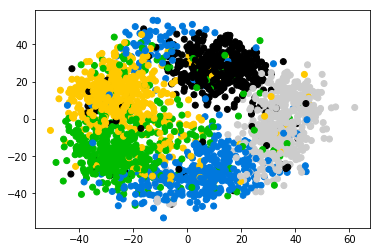

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='nipy_spectral')

# Decision trees out of the box

DecisionTreeClassifier has a number of parameters:
* max_depth : a limit on tree depth (default : no limit)
* min_samples_split : there should be at least this many samples to split further (default : 2)
* min_samples_leaf : there should be at least this many samples on one side of a split to consider it valid (default : 1).
* criterion : 'giny' or 'entropy' - split stuff over this parameter (default : giny)

In [9]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 6, min_samples_split = 15, min_samples_leaf = 10)
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Plot decision surface

This function takes your classifier and plots it's prediction at each point. Let's see how it works.

In [10]:
from sklearn.metrics import accuracy_score
def plot_decision_surface(clf, X, y, plot_step = 0.2, cmap='nipy_spectral', figsize=(12,8)):
    """ plot the decision boundary of clf on X and y, visualize training points"""
    plt.figure(figsize=figsize)
    x0_grid, x1_grid = np.meshgrid(np.arange(X[:, 0].min() - 1, X[:, 0].max() + 1, plot_step),
                         np.arange(X[:, 1].min() - 1, X[:, 1].max() + 1, plot_step))
    y_pred_grid = clf.predict(np.stack([x0_grid.ravel(), x1_grid.ravel()],axis=1)).reshape(x1_grid.shape)
    plt.contourf(x0_grid, x1_grid, y_pred_grid, cmap=cmap, alpha=0.5)  
    y_pred = clf.predict(X)    
    plt.scatter(*X[y_pred==y].T,c = y[y_pred==y],
                marker='.',cmap=cmap,alpha=0.5,label='correct')
    plt.scatter(*X[y_pred!=y].T,c = y[y_pred!=y],
                marker='x',cmap=cmap,s=50,label='errors')
    plt.legend(loc='best')
    print("Accuracy = ",accuracy_score(y, y_pred))
    plt.show()

### Train quality

Accuracy =  0.8339253996447602


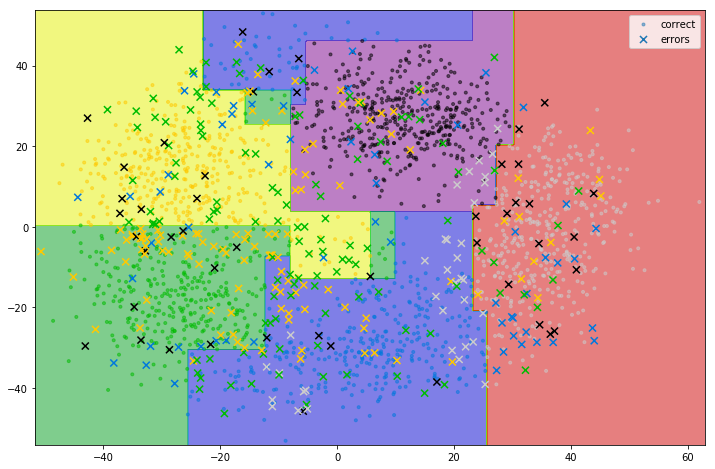

In [11]:
plot_decision_surface(tree,X_train,y_train)

### Test quality


__Before you run it:__ guess what's gonna happen with test accuracy vs train accuracy judging by the train plot?

Accuracy =  0.7891699955614736


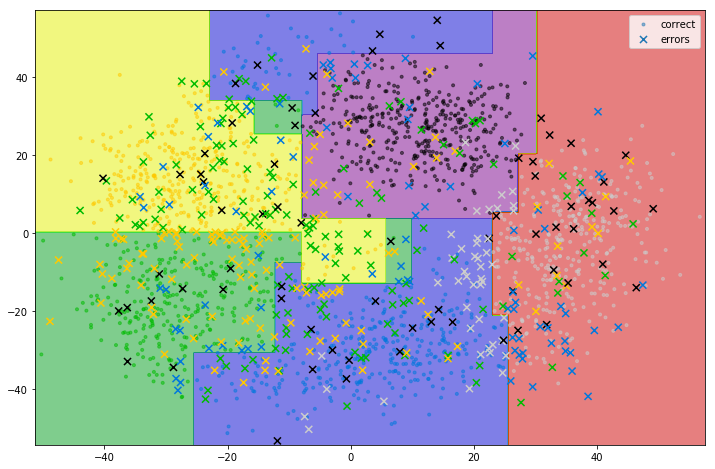

In [12]:
plot_decision_surface(tree,X_test,y_test)

```

```

```

```

```

```

```

```


### We need a better tree!

Try adjusting parameters of DecisionTreeClassifier to improve test accuracy.
 * Accuracy >= 0.72 - not bad for a start
 * Accuracy >= 0.75 - better, but not enough
 * Accuracy >= 0.77 - pretty good
 * Accuracy >= 0.78 - great! (probably the best result for a single tree)
 
Feel free to modify the DecisionTreeClassifier above instead of re-writing everything.

__Note:__ some of the parameters you can tune are under the "Decision trees out of the box" header.

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


### Ensembles

Let's build our own decision tree bagging and see if it works. Implement __`BagOfTrees`__ class below

In [13]:
class BagOfTrees:
    
    def __init__(self, n_estimators=10, **kwargs):
        self.trees = []
        for i in range(n_estimators):
            self.trees.append(DecisionTreeClassifier(**kwargs))
            
    def fit(self, X, y):
        
        # Fit each of the trees on a random subset of X and y.
        # hint: you can select random subsample of data liek this:
        # >>> ix = np.random.randint(0, len(X), len(X))
        # >>> X_sample, y_sample = X[ix], y[ix]
        for tree in self.trees:
            ix = np.random.randint(0, len(X), len(X))
            X_sample, y_sample = X[ix], y[ix]
            tree.fit(X_sample, y_sample)
            
        
        
    def predict(self, X):
        trees = self.trees
        score = 0
        # Compute predictions of each tree and aggregate them into the ensemble prediction
        # Note: you can use tree.predict(X) or tree.predict_proba(X) to get individual predicitons
        for tree in trees:
            score += tree.predict_proba(X)
        return np.argmax(score, axis = 1)
    
# once you thing you're done, see if your code passes asserts below

In [14]:
model = BagOfTrees(n_estimators=100, min_samples_split=5, max_depth = 5)
model.fit(X_train,y_train)

In [15]:
print('\n'.join(map(str, model.trees[:2])))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [16]:
pred = model.predict(X_test[::100])
print("predictions:", pred)
assert isinstance(pred, np.ndarray), "prediction must be a numpy array"
assert str(pred.dtype).startswith('int'), "prediction dtype must be integer (int32/int64)"
assert pred.ndim == 1, "prediction must be a vector (1-dimensional)"
assert len(pred) == len(X_test[::100]), "must predict exactly one answer for each input (expected length %i, got %i)" % (len(X_test[::100]), len(pred))
assert any(model.trees[0].predict(X_train) != model.trees[1].predict(X_train)), "All trees are the same. Did you forget to train each tree on a random part of data?"

predictions: [0 3 0 0 0 1 2 3 4 3 0 3 2 0 2 1 1 0 1 3 1 3 2]


In [17]:
for i, tree in enumerate(model.trees[:5]):
    print("tree %i individual accuracy = %.5f"%(i+1, accuracy_score(y_test,tree.predict(X_test))))

tree 1 individual accuracy = 0.78251
tree 2 individual accuracy = 0.77630
tree 3 individual accuracy = 0.77319
tree 4 individual accuracy = 0.77852
tree 5 individual accuracy = 0.78162


In [18]:
print("Ensemble accuracy:", accuracy_score(model.predict(X_test), y_test)) # should be >= 0.79

Ensemble accuracy: 0.7940523746116289


Accuracy =  0.7940523746116289


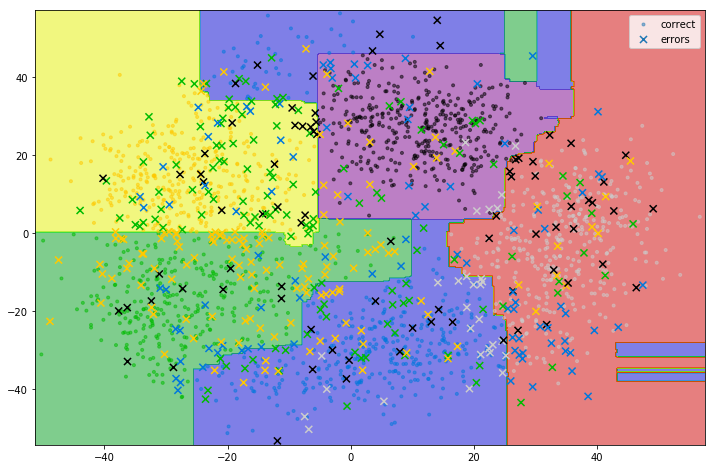

In [19]:
plot_decision_surface(model, X_test, y_test)


### Using  existing ensembles : Random Forest

RandomForest combines bagging and random subspaces: each tree uses a fraction of training samples and while split in that tree is chosen among a subset of features. This leads to a slightly better performance.

__Note:__ try re-running your code a few times and see what happens to accuracy.

Accuracy =  0.7967154904571683


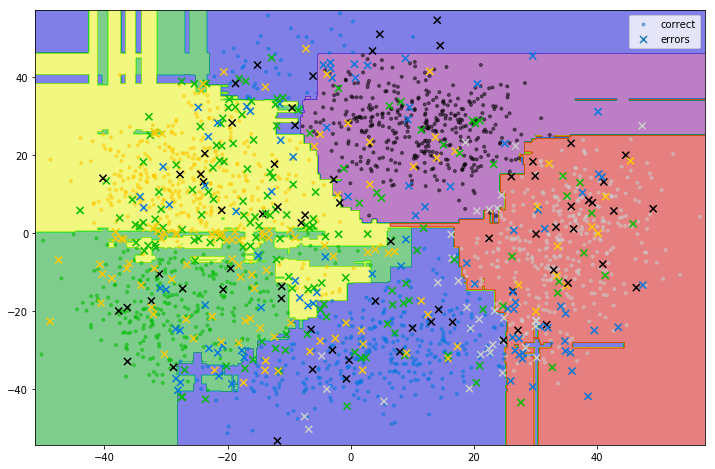

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Task: create and fit a random forest with 100 estimators and at least 5 samples per leaf

model = RandomForestClassifier(n_estimators = 8, min_samples_leaf = 5, criterion = 'entropy') 
model.fit(X_train, y_train)

plot_decision_surface(model, X_test, y_test)

In [22]:
acc = accuracy_score(model.predict(X_test), y_test)
assert acc >= 0.792, "acc is below 0.792. Try changing random forest hyperparameters."

### Using existing ensembles : Gradient Boosting

__Note:__ if you don't have xgboost, use from sklearn.ensemble import GradientBoostingClassifier as XGBClassifier

In [23]:
#from sklearn.ensemble import GradientBoostingClassifier as XBGClassifier
from xgboost import XGBClassifier, XGBRegressor

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
_X = np.linspace(-5,5,50)
_y = 1. / (1. + np.e**(-_X))
plt.plot(_X,_y)
clf = XGBRegressor(n_estimators = 100, learning_rate = .1, max_depth = 1).fit(_X.reshape([-1,1]),_y)
plt.plot(_X, clf.predict(_X.reshape([-1,1])))


In [ ]:
import warnings
warnings.simplefilter("ignore")
from IPython.display import clear_output
from time import sleep

In [ ]:
for n_estimators in range(1,10):
    model = XGBClassifier(max_depth=3, learning_rate=0.5, n_estimators=n_estimators)
    model.fit(X_train, y_train)

    print("n_estimators = ", n_estimators)
    plot_decision_surface(model, X_test, y_test)
    
    

### Grid search

__Bonus Quest:__ Find optimal parameters for GradientBoostingClassifier using grid search.

This time please use a special validation set (i.e. don't make decisions based on X_test, y_test).

You can implement a loop that searches over max_depth and learning_rate for a __fixed n_estmators=100__.

In [ ]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

In [ ]:
%%time
%%notify
from sklearn.model_selection import BayesianSearchCV
X_1, X_2, y_1, y_2 = train_test_split(X_test, y_test, test_size=0.9, random_state=0)
model = XBGClassifier()
params = {'max_depth' : np.linspace(1,7,7), 'learning_rate' : np.logspace(-4,0,15),\
         'n_estimators' : range(1,50)}
clf = BayesianSearchCV(model, params, n_jobs = -1)
clf.fit(X_1, y_1)


In [ ]:
import pickle
with open("model.pcl", "wb") as f:
    pickle.dump(model,f)

In [ ]:
bp = clf.best_params_
print(bp)

In [ ]:
final_model = XBGClassifier(n_estimators = 10, max_depth = bp['max_depth'], learning_rate = bp['learning_rate'])
final_model.fit(X_1, y_1)
plot_decision_surface(final_model,X_2,y_2)



### Automatic ML: model selection

While grid search is reasonably good for parameter optimization, it oftentimes spends a lot of times exploring hopeless regions. There are other approaches to finding optimal model that can result in drastically smaller cpu time.

The first approach is __bayesian optimization__, whos main idea is to model probability density function of a score (e.g. accuracy) at every point and explore points that are most likely to give optimal solution. The "wilingness to try this point" is called the acquisition function.

Here's an example:
![gp](https://cloud.google.com/blog/big-data/2017/08/images/150162099779222/hyperparameter-31-c.png)


The most popular bayesian optimization methods are __gaussian process optimization(GP)__ and __tree-structured parzen estimators (TPE)__, differning mainly in the way they estimate the distributions. 

This time we're gonna see TPE in action using the [modelgym](https://github.com/yandexdataschool/modelgym) package.

_warning: the package is still in early development, some things may suddenly break down_

In [ ]:
!pip install https://github.com/yandexdataschool/modelgym/archive/master.zip > modelgym.log
!pip install lightgbm > lightgbm.log

In [ ]:
from modelgym.models import XGBClassifier # CatBoost gradient boosting
from modelgym.utils import XYCDataset, ModelSpace
from modelgym.metrics import Accuracy

In [ ]:
from modelgym.trainers import TpeTrainer

trainer = TpeTrainer([ModelSpace(XGBClassifier, {'iterations':25})]) #you can add more models here...

trainer.crossval_optimize_params(Accuracy(), XYCDataset(X_train, y_train), cv=3)

In [ ]:
trainer.get_best_results()

An alternative approach here is __stochastic optimization__. If bayesian optimization is like a scalpel that cuts precisely where it should, stochastic optimization is a shotgun that shoots a bunch of pellets and sees which of them are most successful.

We're gonna see this in action with the help of [tpot](https://github.com/EpistasisLab/tpot/) - a library for hyperparameter optimization via genetic programming.

In [ ]:
!pip install tpot > tpot.log

In [ ]:
from tpot import TPOTClassifier

trainer = TPOTClassifier(population_size=50, generations=10, # genetic algorithm params
                         cv=3,                               # 3-fold cross-validation
                         n_jobs=4,                           # parallel processes
                         max_eval_time_mins = 0.5            # model should train in under 30 seconds
                         verbosity=2,
                        )


In [ ]:
trainer.fit(X_train, y_train)

In [ ]:
best_model = trainer.fitted_pipeline_
print("TPOT test accuracy =", accuracy_score(y_test, best_model.predict(X_test)))